In [1]:
import arviz as az
import itertools
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import pandas as pd

from bambi.plots import plot_cap
from bambi.plots.plot_cap import make_main_values, make_group_values
from bambi.plots.plot_comparisons import plot_comparison
from bambi.utils import listify, clean_formula_lhs, get_aliased_name

%load_ext autoreload
%autoreload 2

## Gaussian Linear Model

For the first demonstration, we will use a Gaussian linear regression model to better understand the `plot_cap` function and its arguments. 

In [149]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
data["am"] = pd.Categorical(data["am"], categories=[0, 1], ordered=True)
#data["drat"] = pd.Categorical(data["drat"], ordered=True).codes

In [151]:
# Define and fit the Bambi model
model = bmb.Model("mpg ~ hp * drat * am", data)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, drat, hp:drat, am, hp:am, drat:am, hp:drat:am]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [152]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,13.199,13.415,-13.335,37.366,0.354,0.251,1435.0,1685.0,1.00
hp,-0.014,0.084,-0.179,0.141,0.002,0.002,1331.0,1775.0,1.01
drat,3.735,3.797,-3.023,11.266,0.101,0.073,1410.0,1726.0,1.00
hp:drat,-0.012,0.025,-0.057,0.037,0.001,0.000,1348.0,1806.0,1.00
am[1],2.029,14.087,-22.234,30.039,0.358,0.253,1550.0,2032.0,1.00
hp:am[1],0.055,0.089,-0.112,0.220,0.002,0.002,1469.0,2046.0,1.00
drat:am[1],0.357,3.614,-6.505,6.869,0.098,0.069,1357.0,1737.0,1.00
hp:drat:am[1],-0.013,0.025,-0.056,0.035,0.001,0.000,1378.0,2069.0,1.00
mpg_sigma,3.079,0.449,2.311,3.940,0.009,0.006,2715.0,2410.0,1.00


main: am, group: drat, panel: None


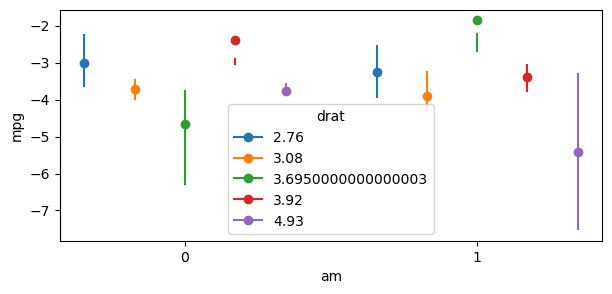

In [161]:
(fig, axes), comparison_df = plot_comparison(
    model,
    idata,
    contrast_predictor={"hp": [110, 175]},
    conditional=["am", "drat"]
)
fig.set_size_inches(7, 3)

### Palmer penguins

In [2]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/palmerpenguins/penguins.csv", index_col=0)
data = data.dropna(axis=0, how="any")

In [3]:
model = bmb.Model(
    "body_mass_g ~ flipper_length_mm * species * bill_length_mm + island",
    data, family="gaussian"
)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_g_sigma, Intercept, flipper_length_mm, species, flipper_length_mm:species, bill_length_mm, flipper_length_mm:bill_length_mm, species:bill_length_mm, flipper_length_mm:species:bill_length_mm, island]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.


main: species, group: None, panel: None


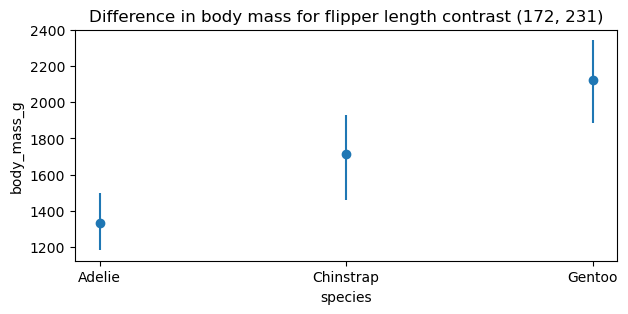

In [130]:
# Not specified:
# bill_length_mm --> held at mean
# island --> held at mode
(fig, axes), contrasts_df = plot_comparison(
    model=model,
    idata=idata,
    contrast_predictor={"flipper_length_mm": [172, 231]},
    conditional=["species"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in body mass for flipper length contrast (172, 231)");

main: island, group: species, panel: None


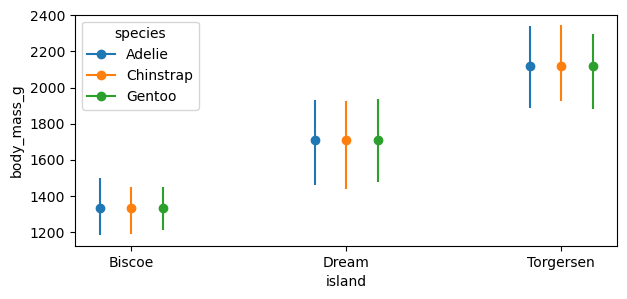

In [129]:
(fig, axes), contrasts_df = plot_comparison(
    model=model,
    idata=idata,
    contrast_predictor={"flipper_length_mm": [172, 231]},
    conditional=["island", "species"]
)
fig.set_size_inches(7, 3)

### Titanic

In [120]:
dat = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv", index_col=0)

In [121]:
dat["PClass"] = dat["PClass"].str.replace("[st, nd, rd]", "", regex=True)
dat["PClass"] = dat["PClass"].str.replace("*", "0").astype(int)
dat["PClass"] = dat["PClass"].replace(0, np.nan)
dat["PClass"] = pd.Categorical(dat["PClass"], ordered=True)
dat["SexCode"] = pd.Categorical(dat["SexCode"], ordered=True)

In [122]:
dat = dat.dropna(axis=0, how="any")

In [123]:
titanic_model = bmb.Model(
    "Survived ~ PClass * SexCode * Age", 
    data=dat, 
    family="bernoulli"
)

titanic_idata = titanic_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Modeling the probability that Survived==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, PClass, SexCode, PClass:SexCode, Age, PClass:Age, SexCode:Age, PClass:SexCode:Age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


main: SexCode, group: None, panel: None


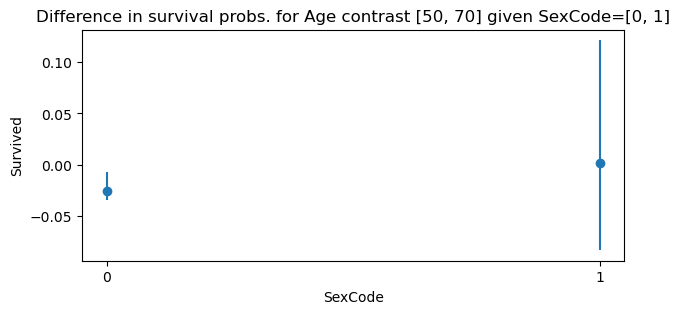

In [135]:
(fig, axes), contrast_df = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"Age": [50, 70]},
    conditional="SexCode"
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for Age contrast [50, 70] given SexCode=[0, 1]");

conditional: {'Age': [50], 'SexCode': [0, 1]}
main: Age, group: SexCode, panel: None


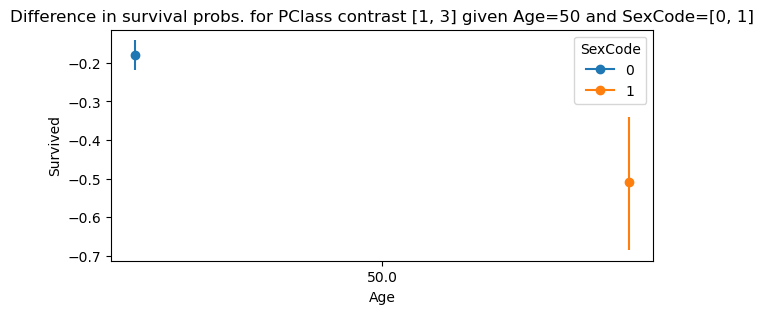

In [134]:
(fig, axes), contrast_df = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"PClass": [1, 3]},
    conditional={"Age": [50], "SexCode": [0, 1]}
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for PClass contrast [1, 3] given Age=50 and SexCode=[0, 1]");